In [1]:
#!/usr/local/bin/python3	

print ('')
print ('** Lab Big Data in Geographic Information Systems **')
print ('*** Module 3: Climate models ***')
print ('')

from netCDF4 import Dataset
import numpy as np
from math import cos, radians
import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from ncdump import ncdump


** Lab Big Data in Geographic Information Systems **
*** Module 3: Climate models ***



In [2]:
#-------------------------------------------------
#-- Task 1 ---------------------------------------
#-------------------------------------------------

#-------------------------------------------------
#-- Explore structure of netCDF file--------------
#-------------------------------------------------

modfile='ts_Amon_IPSL-CM6A-LR_historical_r11i1p1f1_gr_185001-201412.nc'
#modfile='./ts_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc'

#- extract model name
start='ts_Amon_'
end='_historical_r1i1p1f1_gr_185001-201412.nc'
model=modfile[len(start):-len(end)]

nc_fid = Dataset(modfile, 'r')
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

NetCDF Global Attributes:
	name: '/ccc/work/cont003/gencmip6/p86maf/IGCM_OUT/IPSLCM6/PROD/historical/CM61-LR-hist-03.2230/CMIP6/ATM/ts_Amon_IPSL-CM6A-LR_historical_r11i1p1f1_gr_%start_date%-%end_date%'
	Conventions: 'CF-1.7 CMIP-6.2'
	creation_date: '2018-06-18T08:06:45Z'
	tracking_id: 'hdl:21.14100/fa31918b-fe1e-493b-8f1a-5e77edf095dc'
	description: 'CMIP6 historical'
	title: 'IPSL-CM6A-LR model output prepared for CMIP6 / CMIP historical'
	activity_id: 'CMIP'
	contact: 'ipsl-cmip6@listes.ipsl.fr'
	data_specs_version: '01.00.21'
	dr2xml_version: '1.10'
	experiment_id: 'historical'
	experiment: 'all-forcing simulation of the recent past'
	external_variables: 'areacella'
	forcing_index: 1
	frequency: 'mon'
	further_info_url: 'https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM6A-LR.historical.none.r11i1p1f1'
	grid: 'LMDZ grid'
	grid_label: 'gr'
	nominal_resolution: '250 km'
	initialization_index: 1
	institution_id: 'IPSL'
	institution: 'Institut Pierre Simon Laplace, Paris 75252, France'


In [3]:
#-------------------------------------------------
#-- Task 2 ---------------------------------------
#-------------------------------------------------

#-------------------------------------------------
#-- Read data from cetCDF file -------------------
#-------------------------------------------------

fh = Dataset(modfile, mode='r')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mlons = fh.variables['lon'][:]
mlats = fh.variables['lat'][:]
mtime = fh.variables['time'][:]
mts = fh.variables['ts'][:,:,:]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fh.close()

nlon=len(mlons)
nlat=len(mlats)
nmonths=len(mtime)

#- check dimensions
print('nlon=',nlon,'; nlat=',nlat)
print(np.shape(mts))
print(mtime[0:10])

#- Arrange time array
t=np.empty([nmonths],dtype=object)
for ti in range(0,nmonths):
  t[ti] = datetime.date.fromordinal(int(mtime[ti])) + relativedelta(years=1849)  #+datetime.timedelta(days=365*1850)
  #print(ti,mtime[ti],int(mtime[ti]),datetime.date.fromordinal(int(mtime[ti])), t[ti])

mts = mts -273.15   # Kelvin to Celsius

nlon= 144 ; nlat= 143
(1980, 143, 144)
[ 15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5]


In [4]:
#-------------------------------------------------
#-- Make some plots-------------------------------
#-------------------------------------------------

#- First plot map of average temperatures 

#- Set plot
fig = plt.figure(figsize=(9,6))

ax = plt.axes(projection=ccrs.Robinson())

plt.title(' '.join(['Average surface temperature historical simulation \n ',model]))
ax.set_global()

#- calculate time average and convert from Kelvin to Celsius
mts_avg = np.mean(mts,axis=0)#-273.15

#- add cyclic point form plotting purposes
mts_avg_cyc, mlons_cyc = add_cyclic_point(mts_avg, coord=mlons)

#- plot map
mm = ax.pcolormesh(mlons_cyc, mlats, mts_avg_cyc, \
                   transform=ccrs.PlateCarree(),cmap=mpl.cm.gist_ncar )
ax.coastlines()

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Celsius') #($\mu g$ $m^{-3}$)
cbar.ax.tick_params(labelsize=8)

#plt.show()
plt.savefig('Module3_plot01.pdf')
plt.close()

In [5]:
#- Now plot time series of NH average temperatures 

# check axes directions
print(mlats[0],mlats[nlat-1])

#- calculate weighted average
mts_nh = np.ma.zeros([nmonths],dtype=float)*0.0
#print(mts_nh[0:10])
#print("%%%%%%%%%%%%%%%%%%%%")
w = 0.0

for i in range(0,nlon-1):
  for j in range(int(0.5*(nlat)),nlat-1):
    #print(i,j,mlons[i],mlats[j],cos(radians(mlats[j])),mts[:,i,j].mean(),np.mean(mts_nh),w )
    w = w + cos(radians(mlats[j]))
    mts_nh = mts_nh + mts[:,j,i] * cos(radians(mlats[j])) 
    if (mlons[j+1] < 0):
      print("Wrong direction for latitudes !")
      break
mts_nh0=np.divide(mts_nh,w)


#- plot time series

fig = plt.figure(figsize=(9,6))
plt.title(' '.join(['Surface temperature historical simulation - Horthen Hemisphere \n',model]))

#plt.plot(mtime,mts_nh0)
plt.plot(t,mts_nh0)

plt.xlabel('Time')
plt.ylabel('Temp. (Celsius)')

#plt.show()
plt.savefig('Module3_plot02.pdf')
plt.close()

-90.0 90.0


# Task 3
Plot the time series of annual average surface temperature from a model of
your choice, for the Antarctic region (latitudes < 75° S)

Converto il timestamp del dataset in un formato datetime.
Estraggo le informazioni sugli anni.

In [8]:
stt = datetime.date(1850,1,1) 
delta_t = [datetime.timedelta(time)  for time in mtime]
o_t = [stt + delta for delta in delta_t]
years = [date.year for date in o_t]

Costruisco un dizionario che contiene per ogni anno informazioni sulla temperatura dell'area antartica.
Preferisco il dizionario ad un dataframe per motivi di implementazione e di efficienza nell'estrazione dei valori.

In [9]:
antarctic_dict = dict()
mts_antarctic = mts[:,mlats < -75,:]
i = 0
for year in years:
    if year not in antarctic_dict.keys(): # if year is still not present create it
        antarctic_dict[year] = mts_antarctic[i].ravel()
    else: # otherwise append new data
        antarctic_dict[year] = np.concatenate(
                                (antarctic_dict[year],mts_antarctic[i].ravel())
                                )
    i += 1

Calcolo il valore medio per ogni anno

In [10]:
y_avg = [np.mean(antarctic_dict[year]) for year in antarctic_dict]
y_unique = antarctic_dict.keys()

Plotto le informazioni ottenute

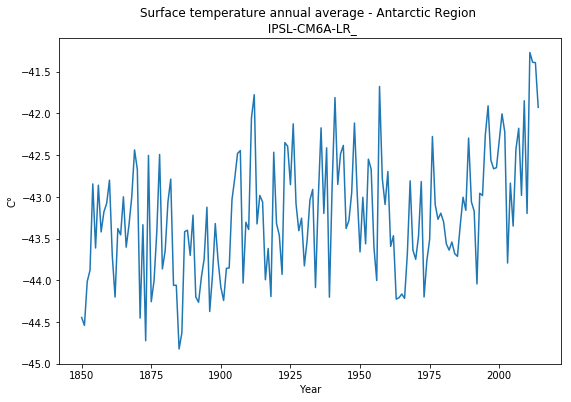

In [13]:
fig = plt.figure(figsize=(9,6))
plt.title(' '.join(['Surface temperature annual average - Antarctic Region \n',model]))
plt.plot(y_unique,y_avg)
plt.xlabel('Year')
plt.ylabel('C°')
plt.show()

# Task 4

Plot the average annual cycle (and variability) of surface temperature around
Milan (45.46° N, 9.19° E) or another location of your choice, as simulated
from one model of your choice

Similarmente a quanto fatto per il Task 3 estraggo stavolta l'informazione sui mesi.

In [15]:
months = [date.month for date in o_t]

Definisco l'area di Pisa impostando un intervallo sia per latitudine che per longitudine

In [16]:
mts_pisa = mts[:,(mlats >= 38) & (mlats <= 48),:]
mts_pisa = mts_pisa[:,:,(mlons >= 185) & (mlons <= 195)]

A differenza del Task 3 questa volta creo sì un dizionario ma con granularità mensile

In [20]:
pisa_dict = dict()
i = 0
for month in months:
    if month not in pisa_dict.keys():
        pisa_dict[month] = mts_pisa[i].ravel()
    else:
        pisa_dict[month] = np.concatenate(
                                (pisa_dict[month],mts_pisa[i].ravel())
                                )
    i += 1

Calcolo il valore medio per mese e plotto le informazioni ottenute andando ad evidenziare in rosso il livello di variabilità per ogni mese

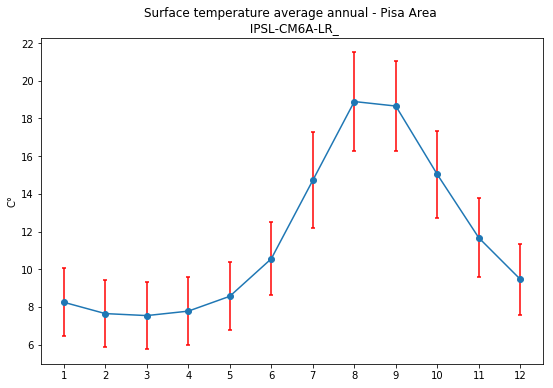

In [25]:
mo_avg = [np.mean(pisa_dict[month]) for month in pisa_dict]
mo_std = [np.std(pisa_dict[month]) for month in pisa_dict]
mo_unique = pisa_dict.keys()
fig = plt.figure(figsize=(9,6))
plt.title(' '.join(['Surface temperature average annual - Pisa Area \n',model]))


plt.errorbar(mo_unique,mo_avg,mo_std,
             capsize = 2, 
             capthick = 1.5,
             marker = 'o',
             ecolor = 'red' # red errorbar
            )

plt.xlabel('Month')
plt.ylabel('C°')
ax = plt.subplot()

# customize the x axis to plot the month names
ax.set_xticks(list(mo_unique))
ax.set_xlabel('')
plt.show()

Per entrambi i task è stato utilizzato il file ts_Amon_IPSL-CM6A-LR_historical_r11i1p1f1_gr_185001-201412.nc